# Rough Bergomi with piecewise constant forward variance

## Structure

- Scale/Normalize Input/Output data
- Train Neural Network: Model Parameters->Implied Volatility Surfaces
- Use Neural Network to calibrate a given smile to parameters


## Authors

Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

## Extract data

In [1]:
import os
os.chdir("..\..\Data")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import matplotlib.ticker as mtick
import time
f = gzip.GzipFile('TrainrBergomiTermStructure.txt.gz', "r")
dat=np.load(f)
print(dat.shape)
xx=dat[:,:11]
yy=dat[:,11:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(80000, 99)
(80000, 11)


In [3]:
xx[0,:]

array([ 0.0989267,  0.13664  ,  0.138692 ,  0.137088 ,  0.103535 ,
        0.0676573,  0.0546302,  0.0185069,  1.09063  , -0.477665 ,
        0.41078  ])

# Scale and Normalize data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    yy, xx, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [6]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

    
[x_train_transform,x_test_transform]=xtransform(X_train,X_test)

def xinversetransform(x):
    return scale2.inverse_transform(x)

In [7]:
# Upper and lower bounds used in the training set
ub=[0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,0,0.5]
lb=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,-1,0.025]
def myscale(x):
    res=np.zeros(11)
    for i in range(11):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(11)
    for i in range(11):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res
    

In [8]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

# Create the Neural Network

In [10]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(11,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 
x4=keras.layers.Dense(30,activation = 'elu')(x3)

x5=keras.layers.Dense(88,activation = 'linear')(x4)

modelGEN = keras.models.Model(inputs=input1, outputs=x5)
modelGEN.summary()


C:\Users\localadmin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 88)                2728      
Total params: 5,878
Trainable params: 5,878
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [43]:
from keras.callbacks import EarlyStopping
patience = 25
NumEpochs=500
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1, 
                          patience=patience)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = NumEpochs, verbose = True,shuffle=1,callbacks=[earlystop])

Train on 68000 samples, validate on 12000 samples
Epoch 1/500
68000/68000 [==============================] - 4s 65us/step - loss: 0.1973 - val_loss: 0.1073
Epoch 2/500
68000/68000 [==============================] - 4s 58us/step - loss: 0.0939 - val_loss: 0.0830
Epoch 3/500
68000/68000 [==============================] - 3s 47us/step - loss: 0.0770 - val_loss: 0.0716
Epoch 4/500
68000/68000 [==============================] - 3s 47us/step - loss: 0.0680 - val_loss: 0.0651
Epoch 5/500
68000/68000 [==============================] - 3s 47us/step - loss: 0.0623 - val_loss: 0.0616
Epoch 6/500
68000/68000 [==============================] - 4s 52us/step - loss: 0.0588 - val_loss: 0.0544
Epoch 7/500
68000/68000 [==============================] - 4s 61us/step - loss: 0.0556 - val_loss: 0.0548
Epoch 8/500
68000/68000 [==============================] - 3s 48us/step - loss: 0.0535 - val_loss: 0.0519
Epoch 9/500
68000/68000 [==============================] - 3s 45us/step - loss: 0.0516 - val_loss: 0.0

68000/68000 [==============================] - 3s 49us/step - loss: 0.0280 - val_loss: 0.0272
Epoch 154/500
68000/68000 [==============================] - 4s 61us/step - loss: 0.0281 - val_loss: 0.0284
Epoch 155/500
68000/68000 [==============================] - 4s 53us/step - loss: 0.0278 - val_loss: 0.0278
Epoch 156/500
68000/68000 [==============================] - 3s 51us/step - loss: 0.0279 - val_loss: 0.0281
Epoch 157/500
68000/68000 [==============================] - 4s 53us/step - loss: 0.0280 - val_loss: 0.0265
Epoch 158/500
68000/68000 [==============================] - 4s 63us/step - loss: 0.0279 - val_loss: 0.0283
Epoch 159/500
68000/68000 [==============================] - 4s 60us/step - loss: 0.0277 - val_loss: 0.0269
Epoch 160/500
68000/68000 [==============================] - 4s 55us/step - loss: 0.0279 - val_loss: 0.0286
Epoch 161/500
68000/68000 [==============================] - 4s 56us/step - loss: 0.0279 - val_loss: 0.0278
Epoch 162/500
68000/68000 [===============

Epoch 229/500
68000/68000 [==============================] - 3s 47us/step - loss: 0.0263 - val_loss: 0.0268
Epoch 230/500
68000/68000 [==============================] - 3s 51us/step - loss: 0.0263 - val_loss: 0.0248
Epoch 231/500
68000/68000 [==============================] - 3s 48us/step - loss: 0.0262 - val_loss: 0.0251
Epoch 232/500
68000/68000 [==============================] - 3s 46us/step - loss: 0.0260 - val_loss: 0.0271
Epoch 233/500
68000/68000 [==============================] - 4s 52us/step - loss: 0.0261 - val_loss: 0.0263
Epoch 234/500
68000/68000 [==============================] - 3s 50us/step - loss: 0.0260 - val_loss: 0.0252
Epoch 235/500
68000/68000 [==============================] - 3s 48us/step - loss: 0.0261 - val_loss: 0.0263
Epoch 236/500
68000/68000 [==============================] - 3s 46us/step - loss: 0.0261 - val_loss: 0.0240
Epoch 237/500
68000/68000 [==============================] - 5s 80us/step - loss: 0.0260 - val_loss: 0.0263
Epoch 238/500
68000/68000 [=

## Store optimal NN parameteres

In [53]:
modelGEN.save_weights('rBergomiTermStructureNNWeights.h5')

In [11]:
modelGEN.load_weights('rBergomiTermStructureNNWeights.h5')

In [12]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Hardcode the Neural Network in NUMPY for performance improvement

In [13]:
NumLayers=4
NumParameters=11
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(NumParameters)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

# Numpy gives roughly 15 fold speed improvement

In [14]:
%timeit NeuralNetwork(y_test_transform[0])

30.9 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit modelGEN.predict(y_test_transform[0].reshape(1,11))

469 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Compute Implied vol relative errors on Test set

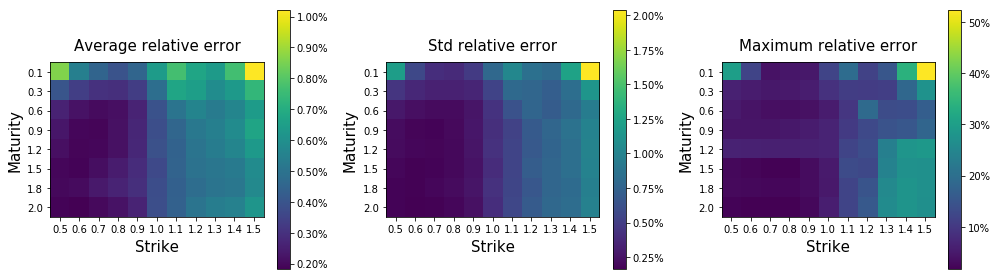

In [17]:
import numpy as np
import csv
import matplotlib.ticker as mtick
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = X_test
y_sample = y_test_transform

prediction=[xinversetransform(NeuralNetwork(y_sample[i])) for i in range(len(y_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('rBergomiTermStructureNNErrors.PNG', dpi=300)
plt.show()

# Plot sample Smiles

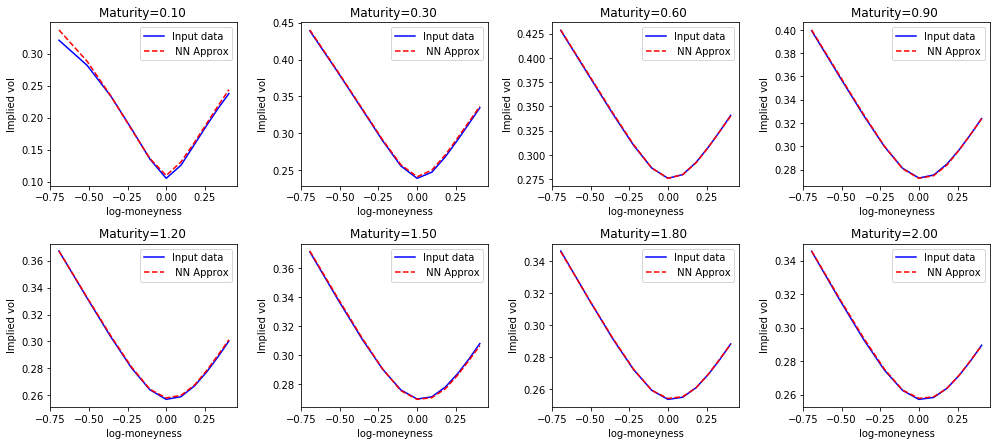

Model Parameters:  [ 0.0120208  0.0992092  0.126305   0.0995428  0.0581061  0.157695
  0.0340984  0.137483   1.63103   -0.060068   0.227925 ]


In [19]:
import scipy
S0=1.

sample_ind = 250
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]

prediction=xinversetransform(NeuralNetwork(y_sample))
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

print("Model Parameters: ",myinverse(y_sample))

# Use gradient methods for optimization

In [48]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-x_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-x_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-x_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [58]:
import time
import scipy
CalibratedParameters=[]
Timing=[]
solutions=np.zeros([4,11])
times=np.zeros(4)
init=np.zeros(11)
for i in range(5000):
    disp=str(i+1)+"/5000"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.clock()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.clock()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    
    CalibratedParameters.append(np.copy(solutions))
    Timing.append(np.copy(times))
    

# Plot calibration times

In [20]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
#plt.legend(methods)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

NameError: name 'Timing' is not defined

# Plot relative errors for levenberg-Marquardt optimal parameters

average=  0.009909834958195486
average=  0.01384682637015444
average=  0.016822720581008067
average=  0.02616733990257942
average=  0.04112297458963902
average=  0.06004062805731214
average=  0.08570431790234273
average=  0.15477554127991433
average=  0.007638141111342179
average=  0.057501922204466156
average=  0.024513397879373542


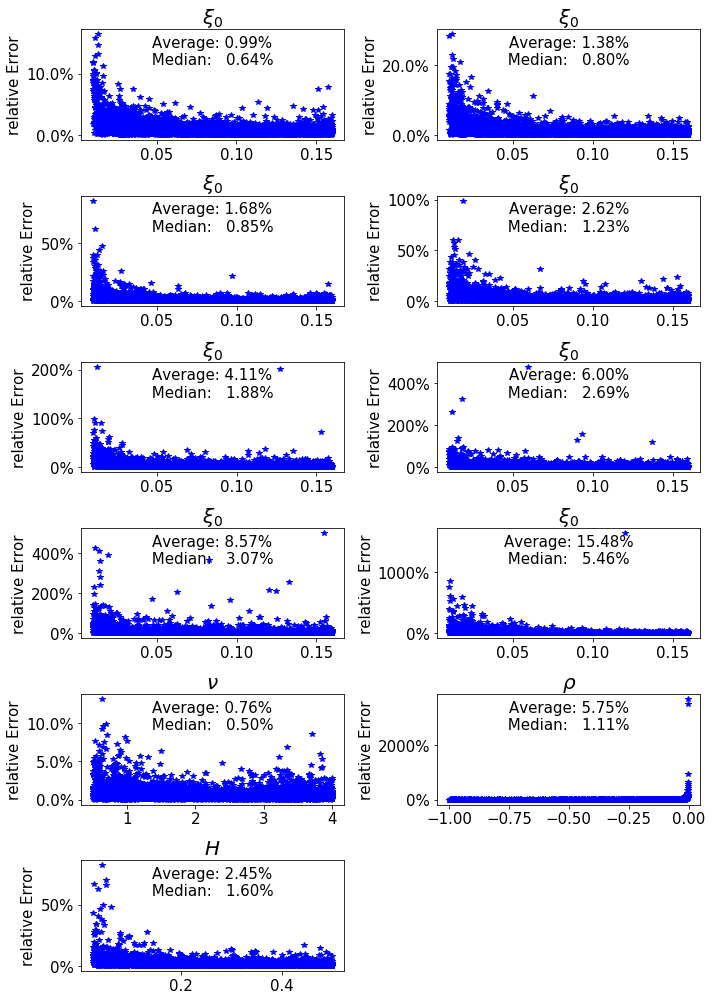

In [64]:
titles=["$\\xi_1$","$\\xi_2$","$\\xi_3$","$\\xi_4$","$\\xi_5$","$\\xi_6$","$\\xi_7$","$\\xi_8$","$\\nu$","$\\rho$","$H$"]
average=np.zeros([11,5000])
fig=plt.figure(figsize=(10,14))
for u in range(11):
    ax=plt.subplot(6,2,u+1)
    for i in range(5000):
        
        y=y_test[i][u]
        plt.plot(y,100*np.abs(CalibratedParameters[i][3][u]-y)/np.abs(y),'b*')
        average[u,i]=np.abs(CalibratedParameters[i][3][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

    print("average= ",np.mean(average[u,:]))
plt.tight_layout()
plt.savefig('rBergomiTermStructureParameterRelativeErrors.png', dpi=300)
plt.show()

In [66]:
LMParameters=[CalibratedParameters[i][3] for i in range(len(CalibratedParameters))]
np.savetxt("NNParametersrBergomiTermStructure.txt",LMParameters)  

In [73]:
Parameters=np.loadtxt("NNParametersr1FactorTermStructure.txt")

In [ ]:
# Compare calibrated surfaces to original ones

In [84]:
# Load surfaces generated using optimal parameters
SurfacesCalib=np.loadtxt("surfacesFromNNRoughBergomiTermStructure.txt")
SurfacesCalib=SurfacesCalib[:,11:]
SurfacesTarget=X_test[:5000]
#We drop indices that don't give implied vols due to MC error
RMSENN=np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget,2),axis=1))
ind=~(RMSENN==np.inf)
RMSENN=RMSENN[ind]
len(RMSENN)

C:\Users\localadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


4941

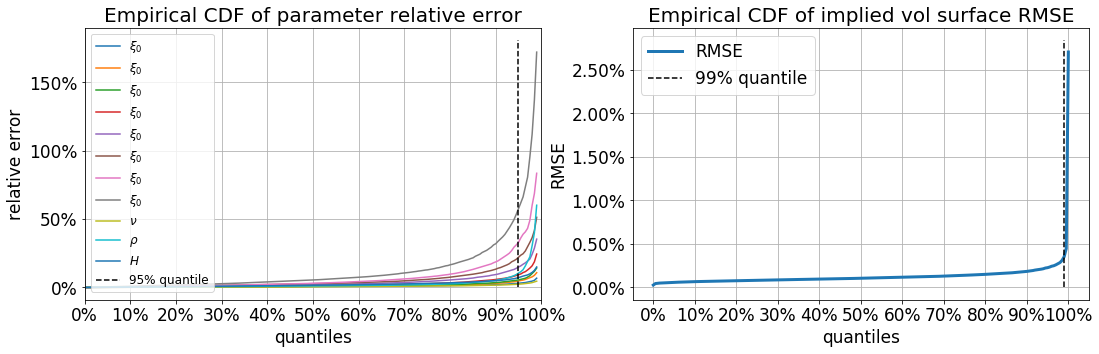

In [86]:
import matplotlib.ticker as mtick
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)


ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(11):
    p=plt.plot(100*q,np.quantile(100*average[u,:],q),label=titles[u])
    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=12)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('rBergomiTermStructureErrorCDF.png', dpi=300)
plt.show()